# Fancy Notebook Name

In [3]:
from pyspark.sql import SparkSession

In [4]:
spark = SparkSession.builder.appName('airbnbReviews').getOrCreate()

In [5]:
# Reviews (without price)
df = spark.read.csv('data/180702_bcn_reviews.csv', header = True, inferSchema = True)

## Explore and Prepare Data

In [6]:
# Review dataframe
df.columns

['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments']

In [7]:
# number of total rows 
df.count()

840588

In [8]:
df.head()

Row(listing_id='18666', id='50158511', date='2015-10-10', reviewer_id='1559265', reviewer_name='Jody', comments='Very nice flat. We had easy transportation to everywhere via the Metro. We could see Sagrada Familia from the terrace. Our hosts helped us with questions we had. Thanks!')

In [9]:
# drop rows without comment
df = df.filter(df['comments']!='')
df.count()

509761

In [10]:
# number of unique listings
df.select('listing_id').distinct().count()

23903

In [11]:
# group df by listing id and concat reviews to one variable
from pyspark.sql.functions import collect_list, concat_ws

grouped_df = df.groupBy('listing_id').agg(concat_ws('.', 
                                                    collect_list('comments')).alias('comments'))

In [70]:
grouped_df.count()

23903

### Join with listing dataframe

In [12]:
# import listings df
df2 = spark.read.csv('data/180702_bcn_listings.csv', header = True, inferSchema=True)

In [13]:
df2.columns

['id',
 'name',
 'host_id',
 'host_name',
 'neighbourhood_group',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'last_review',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']

In [14]:
df2 = df2.select(['id','neighbourhood_group','room_type','price','number_of_reviews'])
df2 = df2.withColumnRenamed('id','listing_id')

In [15]:
df2.columns

['listing_id',
 'neighbourhood_group',
 'room_type',
 'price',
 'number_of_reviews']

In [16]:
# join dataframes
joined_df = grouped_df.join(df2, 'listing_id')

In [17]:
# rename neighbourhood_group
joined_df = joined_df.withColumnRenamed('neighbourhood_group','hood')
joined_df.columns

['listing_id', 'comments', 'hood', 'room_type', 'price', 'number_of_reviews']

In [18]:
joined_df.printSchema()

root
 |-- listing_id: string (nullable = true)
 |-- comments: string (nullable = false)
 |-- hood: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: string (nullable = true)
 |-- number_of_reviews: string (nullable = true)



In [19]:
joined_df.count()

14836

### Prepare numeric variables 

- Price 
- Number of reviews

In [20]:
# convert price to numeric
joined_df = joined_df.select(joined_df.price.cast('float').alias('price'),
                             joined_df.number_of_reviews.cast('float').alias('nr_reviews'),
                            'comments','hood','room_type')

In [21]:
joined_df.count()

14836

In [22]:
# check stats of numeric variables
joined_df.select('price','nr_reviews').describe().show()

+-------+-----------------+------------------+
|summary|            price|        nr_reviews|
+-------+-----------------+------------------+
|  count|            14814|             14822|
|   mean|90.15061539507305| 34.33355822426123|
| stddev|147.1629540675269|48.235761395738045|
|    min|        2.2164626|               1.0|
|    max|           9120.0|             497.0|
+-------+-----------------+------------------+



In [23]:
# filter some extreme values
joined_df = joined_df.filter(joined_df['price'] < 1000)
joined_df = joined_df.filter(joined_df['price'] > 10)
joined_df.count()

14726

In [24]:
import pandas as pd
%matplotlib inline

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1369507f0>]], dtype=object)

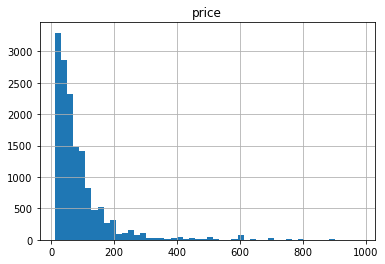

In [132]:
pdf = joined_df.toPandas()
pdf.hist('price', bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x136a6e978>]], dtype=object)

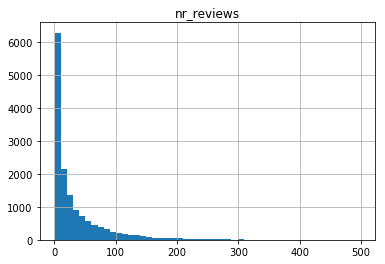

In [136]:
pdf.hist('nr_reviews', bins=50)

### Prepare categorical variables

- Neighborhood (Hood)
- Room Type (room_type)

In [26]:
# Neighbourhood
joined_df.groupBy('hood').count().show()

+-------------------+-----+
|               hood|count|
+-------------------+-----+
|             Gràcia| 1384|
|         Sant Martí| 1689|
|     Horta-Guinardó|  468|
|          Les Corts|  312|
|     Sants-Montjuïc| 1767|
|         Nou Barris|  190|
|Sarrià-Sant Gervasi|  527|
|           Eixample| 5038|
|        Sant Andreu|  217|
|       Ciutat Vella| 3134|
+-------------------+-----+



In [29]:
joined_df = joined_df.where(joined_df['hood'].isin(['Gràcia',
                                 'Sant Martí',
                                 'Horta-Guinardó',
                                 'Les Corts',
                                 'Sants-Montjuïc',
                                 'Nou Barris',
                                 'Sarrià-Sant Gervasi',
                                 'Eixample',
                                 'Sant Andreu',
                                 'Ciutat Vella']))

joined_df.groupBy('hood').count().show()

+-------------------+-----+
|               hood|count|
+-------------------+-----+
|             Gràcia| 1384|
|         Sant Martí| 1689|
|     Horta-Guinardó|  468|
|          Les Corts|  312|
|     Sants-Montjuïc| 1767|
|         Nou Barris|  190|
|Sarrià-Sant Gervasi|  527|
|           Eixample| 5038|
|        Sant Andreu|  217|
|       Ciutat Vella| 3134|
+-------------------+-----+



In [30]:
joined_df.groupBy('room_type').count().show()

+---------------+-----+
|      room_type|count|
+---------------+-----+
|    Shared room|  105|
|Entire home/apt| 7049|
|   Private room| 7572|
+---------------+-----+



In [31]:
# convert both variables to categorical data
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol='hood', outputCol="hoodIndex")
indexed_df = indexer.fit(joined_df).transform(joined_df)

indexer = StringIndexer(inputCol='room_type', outputCol="roomIndex")
indexed_df = indexer.fit(indexed_df).transform(indexed_df)

indexed_df.columns

['price',
 'nr_reviews',
 'comments',
 'hood',
 'room_type',
 'hoodIndex',
 'roomIndex']

### Scatterplot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13b774518>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x118be34e0>]], dtype=object)

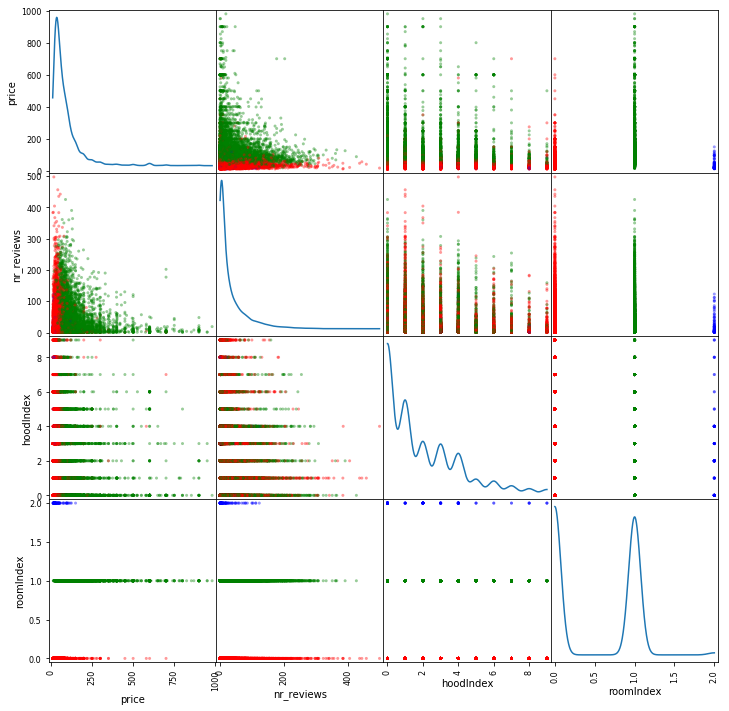

In [176]:
pdf = indexed_df.select('price',
                       'nr_reviews',
                       'hoodIndex',
                       'roomIndex').toPandas()

from pandas.plotting import scatter_matrix
import sys

colors_palette = {0: "red", 1: "green", 2: "blue"}
colors = [colors_palette[c] for c in pdf['roomIndex']]   

scatter_matrix(pdf, alpha=0.4, figsize=(12, 12), diagonal='kde', color = colors)

# Text Data Classifiaction

Can we predict the room type from the reviews? Do people use different language, when they share the apartment, or even the room with the host as when they live by their own?



In [32]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.functions import col,udf
from pyspark.sql.types import IntegerType

In [41]:
# select room and comments
nlp_df = indexed_df.select('room_type','comments')
nlp_df.show()

+---------------+--------------------+
|      room_type|            comments|
+---------------+--------------------+
|Entire home/apt|This flat was per...|
|   Private room|The host canceled...|
|   Private room|We've been welcom...|
|Entire home/apt|Great place, we v...|
|   Private room|The host canceled...|
|Entire home/apt|A very pleasurabl...|
|Entire home/apt|The apartment was...|
|   Private room|Vincent's apartme...|
|    Shared room|Its was a good st...|
|   Private room|La anfitriona muy...|
|   Private room|L'appartamento è ...|
|   Private room|The accommodation...|
|Entire home/apt|Gracias a Marcel,...|
|   Private room|Elba was fantasti...|
|Entire home/apt|very nice flat!We...|
|Entire home/apt|".The host cancel...|
|Entire home/apt|The host canceled...|
|   Private room|Nicolas es un exc...|
|   Private room|Virginia y Carlos...|
|Entire home/apt|Carlos is a perfe...|
+---------------+--------------------+
only showing top 20 rows



### Clean and prepare Data 

In [38]:
from pyspark.sql.functions import length

In [42]:
nlp_df = nlp_df.withColumn('length', length(nlp_df['comments']))
nlp_df.show()

+---------------+--------------------+------+
|      room_type|            comments|length|
+---------------+--------------------+------+
|Entire home/apt|This flat was per...|  4339|
|   Private room|The host canceled...|   551|
|   Private room|We've been welcom...|  4896|
|Entire home/apt|Great place, we v...| 23088|
|   Private room|The host canceled...|  6702|
|Entire home/apt|A very pleasurabl...| 48070|
|Entire home/apt|The apartment was...|  5258|
|   Private room|Vincent's apartme...| 10756|
|    Shared room|Its was a good st...|  3363|
|   Private room|La anfitriona muy...|   866|
|   Private room|L'appartamento è ...| 12010|
|   Private room|The accommodation...| 16676|
|Entire home/apt|Gracias a Marcel,...| 52403|
|   Private room|Elba was fantasti...| 21350|
|Entire home/apt|very nice flat!We...|  2572|
|Entire home/apt|".The host cancel...|  1447|
|Entire home/apt|The host canceled...| 19693|
|   Private room|Nicolas es un exc...| 10521|
|   Private room|Virginia y Carlos

In [43]:
nlp_df.groupBy('room_type').mean().show()

+---------------+------------------+
|      room_type|       avg(length)|
+---------------+------------------+
|    Shared room|3788.1047619047617|
|Entire home/apt| 9234.653851610157|
|   Private room| 6884.842181722134|
+---------------+------------------+



#### Data Pipeline

Defining the steps for the data preparation pipeline.

In [53]:
from pyspark.ml.feature import (Tokenizer,StopWordsRemover,
                                CountVectorizer,IDF,StringIndexer,
                               VectorAssembler)

In [58]:
# convert room_type to numbers
room_type_to_numeric = StringIndexer(inputCol='room_type',outputCol='label')

# Tokenize 
tokenizer = Tokenizer(inputCol='comments',
                      outputCol='token_comment')
# Remove Stopwords
stop_remove = StopWordsRemover(inputCol='token_comment',
                               outputCol='stop_token')
# Count unique terms
count_vec = CountVectorizer(inputCol='stop_token',outputCol='c_vec')

# calculate idf
idf = IDF(inputCol='c_vec', outputCol='tf_idf')

# Write Terms to Vector
clean_up = VectorAssembler(inputCols=['tf_idf','length'],
                          outputCol = 'features')

In [55]:
from pyspark.ml import Pipeline

In [59]:
df_prep_pipe = Pipeline(stages=[room_type_to_numeric,tokenizer,
                               stop_remove,count_vec,idf,clean_up])

In [60]:
cleaner = df_prep_pipe.fit(nlp_df).transform(nlp_df)

In [62]:
clean_data = cleaner.select('label','features')
clean_data.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|(262145,[0,1,2,3,...|
|  0.0|(262145,[3,4,5,11...|
|  0.0|(262145,[0,1,2,3,...|
|  1.0|(262145,[0,1,2,3,...|
|  0.0|(262145,[0,1,2,3,...|
|  1.0|(262145,[0,1,2,3,...|
|  1.0|(262145,[0,1,2,3,...|
|  0.0|(262145,[0,1,2,3,...|
|  2.0|(262145,[0,1,3,4,...|
|  0.0|(262145,[0,1,3,5,...|
|  0.0|(262145,[0,1,2,3,...|
|  0.0|(262145,[0,1,2,3,...|
|  1.0|(262145,[0,1,2,3,...|
|  0.0|(262145,[0,1,2,3,...|
|  1.0|(262145,[0,1,2,3,...|
|  1.0|(262145,[0,1,2,3,...|
|  1.0|(262145,[0,1,2,3,...|
|  0.0|(262145,[0,1,2,3,...|
|  0.0|(262145,[1,3,4,5,...|
|  1.0|(262145,[0,1,2,3,...|
+-----+--------------------+
only showing top 20 rows



### Naive Bayes

In [50]:
from pyspark.ml.classification import NaiveBayes

In [51]:
# use default Naive Baies model
nb = NaiveBayes()

In [64]:
# split into training and test data
training, test = clean_data.randomSplit([0.7,0.3])

In [65]:
training_results = nb.fit(training)

KeyboardInterrupt: 

In [ ]:
test_results = taining_results.transform(test)